In [1]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

In [2]:
import torch
from sklearn.linear_model import LinearRegression

# Final Project: Prediciting NBA Seasons' Most Valuable Players Based On Season Averages of Statistics

### Group Members: Su Hyang Kim and Elton Chan

## Question: Based on NBA player season stat averages, who will recieve the most MVP votes and consequently win the MVP award?

### Interest

Due to the fact that the 2019-2020 NBA season was cut short, it is of high debate of who would have won MVP. Being able to look at past MVP winners' data, we may be able to predict who would have won given these year's season averages. 

### Why this data

This data is relevant because it allows us to calculate the season averages of players from 2012 - 2018. From an external dataset, I was able to import the target values of MVP votes. The feature columns include but are not limited to : points per game, assists, rebounds, and win percentages. By fitting a linear regression to the optimal features within this dataset, we're able to calculate the coefficients that should be applied to these features that would result in the best prediction of MVP points within the seasons presented in this dataset. In further applying this linear model to our season of interest, we may be able to answer our question.

### Procedure

1. Clean columns.
2. Differentiate games into seasons.
3. Group by player name and season for season averages for each player.
4. Only consider "MVP Level" candidates based on minutes played and PPG.
5. Build linear regression model.
6. Train model on training data.
7. Test model on testing data.
8. Apply model to seasons outside of dataset.

### Futher Analysis
Although this data is meant to predict MVP points, the same statistics could be used to predict the other NBA awards, 6 Man of the Year, Rookie of the Year, Defensive player of the Year. This could be extended to most improved but that would entail relating data between seasons.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.relativedelta import relativedelta
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import re

In [4]:
playersdf = pd.read_csv('Basketball-PlayerBoxScore.csv')
playersdf.head(5)

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamDayOff,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,playDispNm,playStat,playMin,playPos,playHeight,playWeight,playBDate,playPTS,playAST,playTO,playSTL,playBLK,playPF,playFGA,playFGM,playFG%,play2PA,play2PM,play2P%,play3PA,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
0,2012-10-30,19:00,Regular,Price,A.J.,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,A.J. Price,Starter,29,PG,74,195,1986-10-07,7,6,1,0,0,1,13,2,0.1538,4,0,0.00,9,2,0.2222,1,1,1.0,1,1,2,CLE,East,Central,Home,Win,0
1,2012-10-30,19:00,Regular,Ariza,Trevor,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Trevor Ariza,Starter,25,SG,80,200,1985-06-30,9,4,0,3,2,0,8,3,0.3750,4,1,0.25,4,2,0.5000,2,1,0.5,1,2,3,CLE,East,Central,Home,Win,0
2,2012-10-30,19:00,Regular,Okafor,Emeka,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Emeka Okafor,Starter,25,C,82,255,1982-09-28,10,0,1,0,4,1,10,4,0.4000,10,4,0.40,0,0,0.0000,4,2,0.5,5,2,7,CLE,East,Central,Home,Win,0
3,2012-10-30,19:00,Regular,Beal,Bradley,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Bradley Beal,Starter,22,SG,77,202,1993-06-28,8,3,2,1,0,1,8,2,0.2500,4,0,0.00,4,2,0.5000,2,2,1.0,0,3,3,CLE,East,Central,Home,Win,0
4,2012-10-30,19:00,Regular,Booker,Trevor,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Trevor Booker,Starter,17,PF,79,240,1987-11-25,4,1,4,1,1,4,9,2,0.2222,8,2,0.25,1,0,0.0000,0,0,0.0,1,0,1,CLE,East,Central,Home,Win,0


# Exploratory Data Analysis

Took a small sample of the data here so plotting would be simplified. 

In [5]:
visual_data = playersdf.sample(n = 10000, random_state = 35)

### Scatter plot of relationship between total rebounds and 3 points attempted, differentiated by the position of the player. The plot also includes some noise to better see the colors.
The plot shows an inverse relationship between rebounding and attempting 3 pointers. If a player rebounds more, they are less likely to attempt a 3 and vice versa. The hues are also helpful in noting that centers rebound more while guards attempt more 3's.

Text(0.5, 1.0, 'Total Rebounds and 3PA between Different Positions')

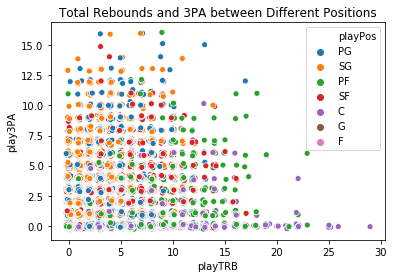

In [6]:
sns.scatterplot(x = visual_data['playTRB'] + np.random.normal(0,0.1,len(visual_data['playTRB']))
                , y = visual_data['play3PA']+ np.random.normal(0,0.1,len(visual_data['play3PA']))
                , hue = visual_data['playPos'])
plt.title('Total Rebounds and 3PA between Different Positions')

### Histogram of points scored throughout the games.

The histogram shows a exponential decaying trend in points scored. Suggesting that there are much fewer games where players score higher and higher. By setting bins to 1, we notice that a large majority of players, slightly above 10%, score 0 points in that given game.

Text(0.5, 1.0, 'Distribution of Points Scored')

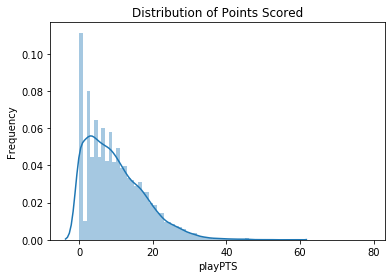

In [7]:
bins = np.arange(0,80)
sns.distplot(visual_data['playPTS'],bins = bins, hist = True)
plt.ylabel('Frequency')
plt.title('Distribution of Points Scored')

### Histogram of minutes played throughout the games.
The histogram shows two bumps in the data of minutes played. There is a small portion of the players that play between 0 and 10 minutes with most of them being in the 5 minute range. After this dip at the 10 min mark, the second bump begins and ends at around 50 minutes played. Factoring in player fatigue and the fact that most regulation games are 48 minutes, this steep drop of minutes played around the 35 minute mark seems natural.

Text(0, 0.5, 'Frequency')

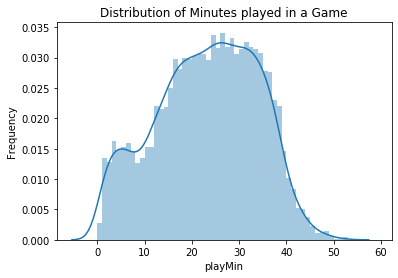

In [8]:
bins = np.arange(0,60)
sns.distplot(visual_data['playMin'],bins = bins, hist = True)
plt.title('Distribution of Minutes played in a Game')
plt.ylabel('Frequency')

### Histogram of assists by players.
This histogram shows the distribution of assists throughout the games. This exponential decay can be explained of the fact that players must be relatively skilled to record assists. More assists per game becomes much harder to achieve as the number becomes large, showing a much lower distribution near the higher amount of assists.

Text(0.5, 1.0, 'Distribution of Assists By Players')

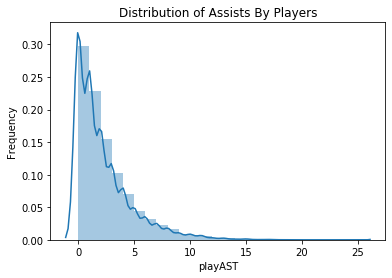

In [9]:
bins = np.arange(0,20)
sns.distplot(visual_data['playAST'],bins = bins, hist = True)
plt.ylabel('Frequency')
plt.title('Distribution of Assists By Players')

### Histogram of 2 pointers attempted by players.
This histogram shows the disbrituion of 2 pointers attempted throughout the games. This trend also follows an exponential decaying trend, indicating that fewer players over fewer games take more 2 pointers.

Text(0.5, 1.0, 'Distribution of 2 Pointers Attempted')

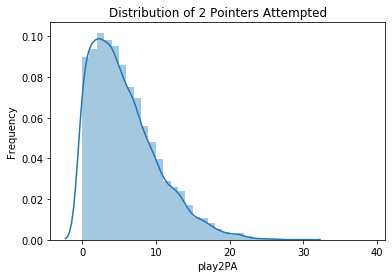

In [10]:
bins = np.arange(0,40)
sns.distplot(visual_data['play2PA'],bins = bins, hist = True)
plt.ylabel('Frequency')
plt.title('Distribution of 2 Pointers Attempted')

### Histogram of 3 pointers attempted by players.
This histogram shows the distribution of 3 pointers attempted throughout the games. This trend follows a stronger exponential decay then the 2 pointers distribution, indicating that 3 pointers are attempted even less. There is a large distribution of players that attempt 0 3 pointers.

Text(0.5, 1.0, 'Distribution of 3 Pointers Attempted')

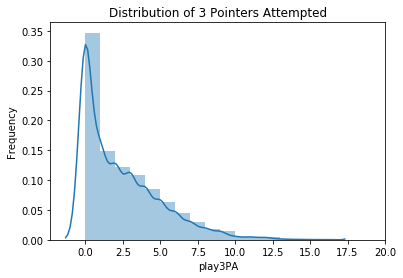

In [11]:
bins = np.arange(0,20)
sns.distplot(visual_data['play3PA'],bins = bins, hist = True)
plt.ylabel('Frequency')
plt.title('Distribution of 3 Pointers Attempted')

Text(0.5, 1.0, 'Points Scored VS Minutes Played')

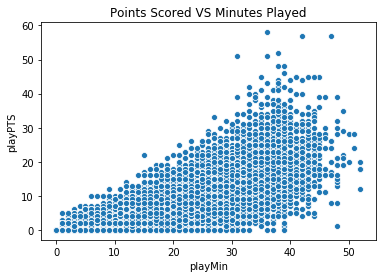

In [12]:
sns.scatterplot(x = 'playMin', y = 'playPTS', data = visual_data)
plt.title('Points Scored VS Minutes Played')

# Data Cleaning / Feature Engineering

Dropping unnecessary columns

In [13]:
playersdf = playersdf.drop(columns = ["offLNm1", "offFNm1", "offLNm2", 'offFNm2', 'offLNm3', 'offFNm3', 'playLNm', 'playFNm', 
                                     'opptAbbr', 'opptConf', 'opptDiv', 'opptLoc', 'opptRslt', 'opptDayOff', 'seasTyp', 
                                      'teamConf', 'teamDiv', 'teamLoc', 'teamDayOff'])

Create Year and Month columns

In [14]:
playersdf['Year'] = playersdf['gmDate'].str[0:4].astype(int)
playersdf['Month'] = playersdf['gmDate'].str[5:7].astype(int)

Create Season column and dropping others

In [15]:
years = [playersdf.iloc[i, 32] if playersdf.iloc[i, 33] > 9 else (playersdf.iloc[i, 32] - 1) for i in np.arange(len(playersdf))]
playersdf['SeasonStart'] = np.array(years)
playersdf['SeasonEnd'] = np.array(years) + 1
playersdf['Season'] = playersdf['SeasonStart'].astype(str) + " - " + playersdf['SeasonEnd'].astype(str)
playersdf = playersdf.drop(columns = ['SeasonStart', 'SeasonEnd', 'Month', 'Year', 'gmDate'])

Added Win/Loss column (1 for Win, 0 for Loss)

In [16]:
playersdf['Win'] = [1 if i == 'Win' else 0 for i in playersdf['teamRslt']]
playersdf['Bench'] = [1 if i == 'Bench' else 0 for i in playersdf['playStat']]
playersdf = playersdf.drop(columns = 'teamRslt')

### EDA guided cleaning
Created player_str that is string of all players with over 2000 minutes in at least one season. This part of the cleaning was guided by the fact that the histogram showed many players taking a much fewer amount of shows, play a much fewer amount of minutes. These players would present large amounts of bias to fitting and predicting MVP votes. 

In [17]:
weeding = playersdf.groupby(['Season', 'playDispNm']).sum().round(2)
weeding = weeding[weeding['playMin'] > 2000]
weeding = weeding.reset_index()
players_with_over_2000 = weeding['playDispNm'].tolist()
player_str = ""
for player in players_with_over_2000:
    player_str = player_str + "|" + player
    
player_str = player_str[1:]

playersdf now only contains games of players with over 2000 minutes in the same season

In [18]:
playersdf = playersdf[playersdf['playDispNm'].str.contains(player_str)]
playersdf.head(5)

,gmTime,teamAbbr,playDispNm,playStat,playMin,playPos,playHeight,playWeight,playBDate,playPTS,playAST,playTO,playSTL,playBLK,playPF,playFGA,playFGM,playFG%,play2PA,play2PM,play2P%,play3PA,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,Season,Win,Bench
1,19:00,WAS,Trevor Ariza,Starter,25,SG,80,200,1985-06-30,9,4,0,3,2,0,8,3,0.3750,4,1,0.2500,4,2,0.5000,2,1,0.5,1,2,3,2012 - 2013,0,0
2,19:00,WAS,Emeka Okafor,Starter,25,C,82,255,1982-09-28,10,0,1,0,4,1,10,4,0.4000,10,4,0.4000,0,0,0.0000,4,2,0.5,5,2,7,2012 - 2013,0,0
3,19:00,WAS,Bradley Beal,Starter,22,SG,77,202,1993-06-28,8,3,2,1,0,1,8,2,0.2500,4,0,0.0000,4,2,0.5000,2,2,1.0,0,3,3,2012 - 2013,0,0
6,19:00,WAS,Martell Webster,Bench,23,SG,81,210,1986-12-04,9,1,0,2,0,1,6,4,0.6667,3,3,1.0000,3,1,0.3333,0,0,0.0,0,3,3,2012 - 2013,0,1
12,19:00,CLE,Kyrie Irving,Starter,35,PG,75,191,1992-03-23,29,3,4,0,1,4,20,11,0.5500,14,8,0.5714,6,3,0.5000,5,4,0.8,0,6,6,2012 - 2013,1,0


Data for amount of MVP votes
Includes name, season, and amount of MVP votes.

In [19]:
MVP_votes = [['LeBron James', '2012 - 2013', 1207],
             ['Kevin Durant', '2012 - 2013', 765],
             ['Carmelo Anthony', '2012 - 2013', 475],
             ['Chris Paul', '2012 - 2013', 289],
             ['Kobe Bryant', '2012 - 2013', 184],
             ['Tony Parker', '2012 - 2013', 86],
             ['Tim Duncan', '2012 - 2013', 65],
             ['James Harden', '2012 - 2013', 33],
             ['Russell Westbrook', '2012 - 2013', 9],
             ['Dwyane Wade', '2012 - 2013', 5],
             ['Stephen Curry', '2012 - 2013', 3],
             ['Kevin Durant', '2013 - 2014', 1232],
             ['LeBron James', '2013 - 2014', 891],
             ['Blake Griffin', '2013 - 2014', 434],
             ['Joakim Noah', '2013 - 2014', 322],
             ['James Harden', '2013 - 2014', 85],
             ['Stephen Curry', '2013 - 2014', 66],
             ['Chris Paul', '2013 - 2014', 45],
             ['Al Jefferson', '2013 - 2014', 34],
             ['Paul George', '2013 - 2014', 33],
             ['LaMarcus Aldridge', '2013 - 2014', 26],
             ['Kevin Love', '2013 - 2014', 25],
             ['Tim Duncan', '2013 - 2014', 21],
             ['Tony Parker', '2013 - 2014', 21],
             ['Dirk Nowitzki', '2013 - 2014', 7],
             ['Carmelo Anthony', '2013 - 2014', 4],
             ['Goran Dragić', '2013 - 2014', 3],
             ['Stephen Curry', '2014 - 2015', 1198],
             ['James Harden', '2014 - 2015', 936],
             ['LeBron James', '2014 - 2015', 552],
             ['Russell Westbrook', '2014 - 2015', 352],
             ['Anthony Davis', '2014 - 2015', 203],
             ['Chris Paul', '2014 - 2015', 124],
             ['LaMarcus Aldridge', '2014 - 2015', 6],
             ['Marc Gasol', '2014 - 2015', 3],
             ['Blake Griffin', '2014 - 2015', 3],
             ['Stephen Curry', '2015 - 2016', 1310],
             ['Kawhi Leonard', '2015 - 2016', 634],
             ['LeBron James', '2015 - 2016', 631],
             ['Russell Westbrook', '2015 - 2016', 486],
             ['Kevin Durant', '2015 - 2016', 147],
             ['Chris Paul', '2015 - 2016', 107],
             ['Draymond Green', '2015 - 2016', 50],
             ['Damian Lillard', '2015 - 2016', 26],
             ['James Harden', '2015 - 2016', 9],
             ['Kyle Lowry', '2015 - 2016', 6],
             ['Russell Westbrook', '2016 - 2017', 888],
             ['James Harden', '2016 - 2017', 753],
             ['Kawhi Leonard', '2016 - 2017', 500],
             ['LeBron James', '2016 - 2017', 333],
             ['Isaiah Thomas', '2016 - 2017', 81],
             ['Stephen Curry', '2016 - 2017', 52],
             ['Giannis Antetokounmpo', '2016 - 2017', 7],
             ['John Wall', '2016 - 2017', 7],
             ['Anthony Davis', '2016 - 2017', 2],
             ['Kevin Durant', '2016 - 2017', 2],
             ['James Harden', '2017 - 2018', 965],
             ['LeBron James', '2017 - 2018', 738],
             ['Anthony Davis', '2017 - 2018', 445],
             ['Damian Lillard', '2017 - 2018', 207],
             ['Russell Westbrook', '2017 - 2018', 76],
             ['Giannis Antetokounmpo', '2017 - 2018', 75],
             ['Kevin Durant', '2017 - 2018', 66],
             ['DeMar DeRozan', '2017 - 2018', 32],
             ['LaMarcus Aldridge', '2017 - 2018', 6],
             ['Jimmy Butler', '2017 - 2018', 5],
             ['Stephen Curry', '2017 - 2018', 5],
             ['Joel Embiid', '2017 - 2018', 4],
             ['Victor Oladipo', '2017 - 2018', 2]]

Inputed MVP votes

In [20]:
playersdf['MVPvotes'] = np.zeros(len(playersdf))
for row in MVP_votes:
    playersdf.loc[(playersdf['playDispNm'] == row[0]) & (playersdf['Season'] == row[1]) , 'MVPvotes'] = row[2]

Renamed all columns for convenience

In [21]:
playersdf = playersdf.rename(columns = {
    "playDispNm" : "Name",
    "playStat" : "Status",
    "playMin" : "Min",
    "playPos" : "Pos",
    "playHeight" : "Height",
    "playWeight" : "Weight",
    "playBDate" : "Birthday",
    "playPTS" : "PTS",
    "playAST" : "AST",
    "playTO" : "TO",
    "playSTL": "STL",
    "playBLK" : "BLK",
    "playPF" : "PF",
    "playFGA" : "FGA",
    "playFGM" : "FGM",
    "playFG%" : "FG%",
    "play2PA" : "2PA",
    "play2PM" : "2PM",
    "play2P%" : "2P%",
    "play3PA" : "3PA",
    "play3PM" : "3PM",
    "play3P%" : "3P%",
    "playFTA" : "FTA",
    "playFTM" : "FTM",
    "playFT%" : "FT%",
    "playORB" : "ORB",
    "playDRB" : "DRB",
    "playTRB" : "TRB",
})

Example df showing Stephen Curry's MVP votes through 2012-2018

In [22]:
playersdf.loc[playersdf['Name'] == 'Stephen Curry'].groupby(['Season', 'Name']).agg(np.mean)

,,Min,Height,Weight,PTS,AST,TO,STL,BLK,PF,FGA,FGM,FG%,2PA,2PM,2P%,3PA,3PM,3P%,FTA,FTM,FT%,ORB,DRB,TRB,Win,Bench,MVPvotes
Season,Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012 - 2013,Stephen Curry,38.294872,75.0,185.0,22.897436,6.897436,3.064103,1.628205,0.153846,2.538462,17.794872,8.025641,0.446205,10.102564,4.538462,0.445505,7.692308,3.487179,0.435592,3.730769,3.358974,0.809812,0.756410,3.269231,4.025641,0.576923,0.0,3.0
2013 - 2014,Stephen Curry,36.448718,75.0,185.0,24.012821,8.538462,3.769231,1.653846,0.179487,2.487179,17.730769,8.358974,0.469642,9.846154,5.012821,0.513938,7.884615,3.346154,0.414908,4.461538,3.948718,0.785865,0.589744,3.692308,4.282051,0.641026,0.0,66.0
2014 - 2015,Stephen Curry,32.662500,75.0,185.0,23.750000,7.737500,3.112500,2.037500,0.200000,1.975000,16.762500,8.162500,0.483531,8.687500,4.587500,0.522630,8.075000,3.575000,0.435339,4.212500,3.850000,0.813233,0.700000,3.575000,4.275000,0.837500,0.0,1198.0
2015 - 2016,Stephen Curry,34.240506,75.0,185.0,30.063291,6.670886,3.303797,2.139241,0.202532,2.037975,20.215190,10.189873,0.499701,8.987342,5.101266,0.576678,11.227848,5.088608,0.439170,5.063291,4.594937,0.807877,0.860759,4.582278,5.443038,0.898734,0.0,1310.0
2016 - 2017,Stephen Curry,33.392405,75.0,185.0,25.303797,6.620253,3.012658,1.810127,0.227848,2.316456,18.265823,8.544304,0.467541,8.278481,4.443038,0.536651,9.987342,4.101266,0.401347,4.582278,4.113924,0.807649,0.772152,3.708861,4.481013,0.822785,0.0,52.0
2017 - 2018,Stephen Curry,31.960784,75.0,185.0,26.392157,6.058824,3.000000,1.568627,0.156863,2.235294,16.941176,8.392157,0.485475,7.117647,4.235294,0.590333,9.823529,4.156863,0.410371,5.921569,5.450980,0.871433,0.705882,4.411765,5.117647,0.803922,0.0,5.0


Grouped playersdf by player and by season to obtain a season average for each player for each season they played.

In [23]:
szn_average = playersdf.groupby(['Season', 'Name']).mean().round(2)
szn_average.head(5)

Min  Height  Weight    PTS   AST    TO   STL  \
Season      Name                                                              
2012 - 2013 Al Horford       37.26    82.0   245.0  17.42  3.24  1.99  1.05   
            Al Jefferson     33.05    82.0   265.0  17.83  2.10  1.35  1.03   
            Al-Farouq Aminu  27.20    81.0   215.0   7.30  1.34  1.53  1.21   
            Alec Burks       17.75    78.0   195.0   7.02  1.44  1.16  0.55   
            Alonzo Gee       30.96    78.0   219.0  10.27  1.62  1.61  1.30   

                              BLK    PF    FGA   FGM   FG%    2PA   2PM   2P%  \
Season      Name                                                                
2012 - 2013 Al Horford       1.05  2.20  14.32  7.78  0.54  14.24  7.74  0.54   
            Al Jefferson     1.13  2.18  15.85  7.83  0.48  15.63  7.81  0.49   
            Al-Farouq Aminu  0.67  2.01   6.24  2.96  0.45   5.99  2.91  0.46   
            Alec Burks       0.20  1.78   6.05  2.53  0.40   4.61  2.02  0.40   
            Alonzo Gee       0.35  2.43   9.07  3.72  0.41   6.40  2.88  0.45   

                              3PA   3PM   3P%   FTA   FTM   FT%   ORB   DRB  \
Season      Name                                                              
2012 - 2013 Al Horford       0.08  0.04  0.03  2.81  1.81  0.51  2.64  7.59   
            Al Jefferson     0.22  0.03  0.02  2.79  2.14  0.59  2.00  7.23   
            Al-Farouq Aminu  0.25  0.05  0.05  1.80  1.33  0.42  1.83  5.87   
            Alec Burks       1.44  0.52  0.26  2.02  1.44  0.41  0.58  1.69   
            Alonzo Gee       2.67  0.84  0.26  2.50  1.99  0.58  0.91  2.99   

                               TRB   Win  Bench  MVPvotes  
Season      Name                                           
2012 - 2013 Al Horford       10.23  0.57   0.00       0.0  
            Al Jefferson      9.23  0.53   0.00       0.0  
            Al-Farouq Aminu   7.70  0.33   0.07       0.0  
            Alec Burks        2.27  0.50   1.00       0.0  
            Alonzo Gee        3.90  0.29   0.00       0.0

Accounted for too high/low winning percentages and too short minutes due to playing select games. This cleaning leaves us with mostly MVP type candidates in terms of accurate winning percentages, minutes per game, and points per game. These decisions come from the visualization presented earlier for the histograms showing that there were a large number of players who play very few minutes and score 0 points. These players would take away meaning from what it means to have lower amounts of MVP votes. With all things considered, even having 1 MVP vote takes high levels of consideration. Players who play less minutes or score less points have never be shown to gather even 1 MVP point. Thus, cleaning players who fall outside of this category would benefit the accuracy of the model.

In [24]:
szn_average = szn_average[szn_average['Win'] > 0.1]
szn_average = szn_average[szn_average['Win'] < 0.95]
szn_average = szn_average[szn_average['Min'] > 25]
szn_average = szn_average[szn_average['PTS'] > 20]
szn_average.head(5)

Min  Height  Weight    PTS   AST    TO   STL  \
Season      Name                                                              
2012 - 2013 Carmelo Anthony  37.04    80.0   230.0  28.66  2.55  2.61  0.78   
            Dwyane Wade      34.64    76.0   212.0  21.20  5.12  2.81  1.86   
            James Harden     38.21    77.0   218.0  25.94  5.83  3.78  1.82   
            Kevin Durant     38.53    81.0   225.0  28.15  4.62  3.46  1.43   
            Kobe Bryant      38.69    78.0   200.0  27.35  6.01  3.68  1.36   

                              BLK    PF    FGA   FGM   FG%    2PA   2PM   2P%  \
Season      Name                                                                
2012 - 2013 Carmelo Anthony  0.48  3.06  22.22  9.99  0.45  16.04  7.64  0.48   
            Dwyane Wade      0.81  2.03  15.84  8.25  0.52  14.88  8.00  0.54   
            James Harden     0.49  2.28  17.14  7.50  0.44  10.91  5.21  0.47   
            Kevin Durant     1.30  1.77  17.69  9.02  0.52  13.57  7.31  0.55   
            Kobe Bryant      0.32  2.22  20.45  9.46  0.46  15.23  7.77  0.50   

                              3PA   3PM   3P%    FTA   FTM   FT%   ORB   DRB  \
Season      Name                                                               
2012 - 2013 Carmelo Anthony  6.18  2.34  0.35   7.64  6.34  0.82  2.00  4.87   
            Dwyane Wade      0.96  0.25  0.13   6.14  4.46  0.73  1.25  3.74   
            James Harden     6.23  2.29  0.38  10.15  8.64  0.83  0.81  4.06   
            Kevin Durant     4.12  1.72  0.43   9.26  8.38  0.91  0.57  7.33   
            Kobe Bryant      5.22  1.69  0.27   8.03  6.73  0.80  0.85  4.71   

                              TRB   Win  Bench  MVPvotes  
Season      Name                                          
2012 - 2013 Carmelo Anthony  6.87  0.70    0.0     475.0  
            Dwyane Wade      4.99  0.80    0.0       5.0  
            James Harden     4.87  0.55    0.0      33.0  
            Kevin Durant     7.90  0.74    0.0     765.0  
            Kobe Bryant      5.55  0.54    0.0     184.0

### Histogram of MVP votes among players with >25 MPG and >20 PPG
This histogram has a very strong exponential decay trend. More than 25% of this already elite population recieve 0 MVP votes. Using a log function in the linear trend may prove helpful in capturing this behavior.

Text(0.5, 1.0, 'Distribution of MVP votes among players with >25 MPG and >20 PPG')

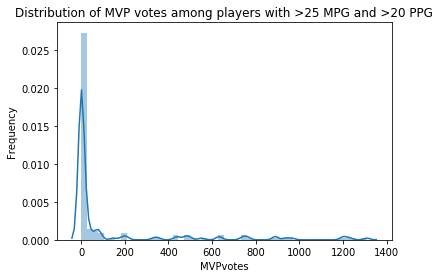

In [25]:
sns.distplot(szn_average['MVPvotes'], hist = True)
plt.ylabel('Frequency')
plt.title('Distribution of MVP votes among players with >25 MPG and >20 PPG')

I decided that in order to further emulate the differences and nuances between each season, the stats had to be seperated by season. Each statistic here represents the how many of each statistic the player recorded above the average for that statistic that season. For example, PTSabove represents how many points players recorded above or below the PPG average for any particular season. This would better capture having higher scoring or lower scoring seasons.

In [26]:
temp = szn_average.reset_index()
temp['PTSabove'] = np.zeros(len(temp))
temp['ASTabove'] = np.zeros(len(temp))
temp['TOabove'] = np.zeros(len(temp))
temp['STLabove'] = np.zeros(len(temp))
temp['BLKabove'] = np.zeros(len(temp))
temp['PFabove'] = np.zeros(len(temp))
temp['FGAabove'] = np.zeros(len(temp))
temp['FGMabove'] = np.zeros(len(temp))
temp['FG%above'] = np.zeros(len(temp))
temp['2PAabove'] = np.zeros(len(temp))
temp['2PMabove'] = np.zeros(len(temp))
temp['2P%above'] = np.zeros(len(temp))
temp['3PAabove'] = np.zeros(len(temp))
temp['3PMabove'] = np.zeros(len(temp))
temp['3P%above'] = np.zeros(len(temp))
temp['FTAabove'] = np.zeros(len(temp))
temp['FTMabove'] = np.zeros(len(temp))
temp['FT%above'] = np.zeros(len(temp))
temp['ORBabove'] = np.zeros(len(temp))
temp['DRBabove'] = np.zeros(len(temp))
temp['TRBabove'] = np.zeros(len(temp))
temp['Winabove'] = np.zeros(len(temp))

columns = ['PTS', 'AST', 'TO', 'STL',
       'BLK', 'PF', 'FGA', 'FGM', 'FG%', '2PA', '2PM', '2P%', '3PA', '3PM',
       '3P%', 'FTA', 'FTM', 'FT%', 'ORB', 'DRB', 'TRB', 'Win']
columns_above = ['PTSabove', 'ASTabove', 'TOabove', 'STLabove', 'BLKabove',
       'PFabove', 'FGAabove', 'FGMabove', 'FG%above', '2PAabove', '2PMabove',
       '2P%above', '3PAabove', '3PMabove', '3P%above', 'FTAabove', 'FTMabove',
       'FT%above', 'ORBabove', 'DRBabove', 'TRBabove', 'Winabove']

np.mean(temp[temp['Season'] == '2012 - 2013']['PTS'])

years = ['2012 - 2013', '2013 - 2014', '2014 - 2015', '2015 - 2016', '2016 - 2017', '2017 - 2018']

for i in np.arange(len(columns)):
    for year in years:
        for name in temp[temp['Season'] == year]['Name']:
            temp.loc[(temp['Season'] == year) & (temp['Name'] == name), columns_above[i]] = (temp.loc[
                (temp['Season'] == year) & (temp['Name'] == name)][columns[i]] - np.mean(temp[temp
                ['Season'] == year][columns[i]]))
        
szn_average = temp.groupby(["Season", "Name"]).agg(np.mean)

# Linear Model


Split data into training and test set by running numbers 1 - 6 into random number generator. The data is split by season to account for the fact that each season and that season's mvp difference. 

In [27]:
#Training/Test set with rng
train = szn_average.reset_index()[szn_average.reset_index()['Season'].str.contains('2012 - 2013|2014 - 2015|2015 - 2016|2017 - 2018')].groupby(['Season', 'Name']).mean().round(2)
test = szn_average.reset_index()[szn_average.reset_index()['Season'].str.contains('2013 - 2014|2016 - 2017')].groupby(['Season', 'Name']).mean().round(2)

Created a function to add the intercept column to X_train that is needed in linear regression. Also imported an ignore warning since we will be taking np.log of many values that are 0, resulting in -inf that should be treated as 0's.

In [28]:
def add_ones_column(X):
    return np.hstack([np.ones((X.shape[0],1)), X])
from numpy import errstate,isneginf
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Created X and Y matrices for both test and train sets. In both the test and training Y column, the value we are trying to predict, notice that the values have been applied to np.log to account for previously mentioned behavior of MVP votes. Tested out many different columns to include in the X matrices. We ran many cross validation scores with rmse as the scoring parameter. 

Model assumptions:                                                                                                 
Data includes the columns listed below under variable name "column".                                               
Data has been cleaned according to the conditions above in the data cleaning section.

In [29]:
#column = ['playPTS', 'playAST', 'playTO', 'playSTL', 'playBLK', 'playPF'
#          ,'playPF', 'playFGA', 'playFGM', 'playFG%', 'play2PA', 'play2PM', 'play2P%', 'play3PA', 'play3PM'
#          ,'play3P%', 'playFTA', 'playFTM', 'playFT%', 'playORB', 'playDRB', 'playTRB']
#Set list of columns meant to be included in matrix
#column = ['PTSabove', 'ASTabove', 'TOabove', 'STLabove', 'BLKabove',
#       'PFabove', 'FGAabove', 'FGMabove', 'FG%above', '2PAabove', '2PMabove',
#       '2P%above', '3PAabove', '3PMabove', '3P%above', 'FTAabove', 'FTMabove',
#       'FT%above', 'ORBabove', 'DRBabove', 'TRBabove', 'Winabove']
column = ['PTSabove', 'ASTabove', 'TOabove', 'STLabove', 'BLKabove',
       'PFabove', 'FG%above',
       'FT%above', 'ORBabove', 'DRBabove', 'Winabove']
X = train[column].to_numpy()
#took the log of MVP votes
#Y = train[['MVPvotes']].to_numpy()
Y = np.log(train[['MVPvotes']].to_numpy())
#Replaced -inf with 0
Y[isneginf(Y)] = 0

#Same for test data
X_test = test[column].to_numpy()
#Y_test = test[['MVPvotes']].to_numpy()
Y_test = np.log(test[['MVPvotes']].to_numpy())
Y_test[isneginf(Y_test)] = 0

Ran Ridge, lasso, and linear regression model but decided regular linear regression model resulted in lowest cross_val_score value.

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
#model = Ridge(alpha = 0.95, normalize = True)
model = LinearRegression()
#model = linear_model.Lasso(alpha=0.95)

Fitting of model.

In [31]:
model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Values of RMSE for test and train before accounting for the effects of taking np.log with np.e **.

In [32]:
from sklearn.model_selection import cross_val_score
def rmse_score(model, X, Y):
    return np.sqrt(np.mean((Y - model.predict(X))**2))
print("Training RMSE:" + str(np.mean(cross_val_score(model, X, Y, scoring=rmse_score, cv=5))))
print("Test RMSE:" + str(np.mean(cross_val_score(model, X_test, Y_test, scoring=rmse_score, cv=5))))

Training RMSE:1.7278688064600949
Test RMSE:1.9480542066368471


Obversation of coefficients.

In [33]:
for i in np.arange(len(column)):
    print(column[i], model.coef_[0,i])

PTSabove 0.5071951448980649
ASTabove 0.5619969600834318
TOabove -0.6111143772550776
STLabove 0.47126728745105384
BLKabove 0.6365130446828208
PFabove -0.466001510461711
FG%above 7.854755742550482
FT%above 1.0943249517236577
ORBabove 0.4996035615863154
DRBabove -0.08743458228970817
Winabove 3.269222095658883


Attaching predicted values to training data to observe.

In [34]:
train['predicted'] = np.e ** model.predict(X)
train.round(2).head(5)

Min  Height  Weight    PTS   AST    TO   STL  \
Season      Name                                                              
2012 - 2013 Carmelo Anthony  37.04    80.0   230.0  28.66  2.55  2.61  0.78   
            Dwyane Wade      34.64    76.0   212.0  21.20  5.12  2.81  1.86   
            James Harden     38.21    77.0   218.0  25.94  5.83  3.78  1.82   
            Kevin Durant     38.53    81.0   225.0  28.15  4.62  3.46  1.43   
            Kobe Bryant      38.69    78.0   200.0  27.35  6.01  3.68  1.36   

                              BLK    PF    FGA   FGM   FG%    2PA   2PM   2P%  \
Season      Name                                                                
2012 - 2013 Carmelo Anthony  0.48  3.06  22.22  9.99  0.45  16.04  7.64  0.48   
            Dwyane Wade      0.81  2.03  15.84  8.25  0.52  14.88  8.00  0.54   
            James Harden     0.49  2.28  17.14  7.50  0.44  10.91  5.21  0.47   
            Kevin Durant     1.30  1.77  17.69  9.02  0.52  13.57  7.31  0.55   
            Kobe Bryant      0.32  2.22  20.45  9.46  0.46  15.23  7.77  0.50   

                              3PA   3PM   3P%    FTA   FTM   FT%   ORB   DRB  \
Season      Name                                                               
2012 - 2013 Carmelo Anthony  6.18  2.34  0.35   7.64  6.34  0.82  2.00  4.87   
            Dwyane Wade      0.96  0.25  0.13   6.14  4.46  0.73  1.25  3.74   
            James Harden     6.23  2.29  0.38  10.15  8.64  0.83  0.81  4.06   
            Kevin Durant     4.12  1.72  0.43   9.26  8.38  0.91  0.57  7.33   
            Kobe Bryant      5.22  1.69  0.27   8.03  6.73  0.80  0.85  4.71   

                              TRB   Win  Bench  MVPvotes  PTSabove  ASTabove  \
Season      Name                                                               
2012 - 2013 Carmelo Anthony  6.87  0.70    0.0     475.0      4.29     -3.06   
            Dwyane Wade      4.99  0.80    0.0       5.0     -3.17     -0.49   
            James Harden     4.87  0.55    0.0      33.0      1.57      0.22   
            Kevin Durant     7.90  0.74    0.0     765.0      3.78     -0.99   
            Kobe Bryant      5.55  0.54    0.0     184.0      2.98      0.40   

                             TOabove  STLabove  BLKabove  PFabove  FGAabove  \
Season      Name                                                              
2012 - 2013 Carmelo Anthony    -0.43     -0.63     -0.10     0.87      4.16   
            Dwyane Wade        -0.23      0.45      0.23    -0.16     -2.22   
            James Harden        0.74      0.41     -0.09     0.09     -0.92   
            Kevin Durant        0.42      0.02      0.72    -0.42     -0.37   
            Kobe Bryant         0.64     -0.05     -0.26     0.03      2.39   

                             FGMabove  FG%above  2PAabove  2PMabove  2P%above  \
Season      Name                                                                
2012 - 2013 Carmelo Anthony      1.34     -0.03      1.92      0.49     -0.02   
            Dwyane Wade         -0.40      0.04      0.76      0.85      0.04   
            James Harden        -1.15     -0.04     -3.21     -1.94     -0.03   
            Kevin Durant         0.37      0.04     -0.55      0.16      0.05   
            Kobe Bryant          0.81     -0.02      1.11      0.62     -0.00   

                             3PAabove  3PMabove  3P%above  FTAabove  FTMabove  \
Season      Name                                                                
2012 - 2013 Carmelo Anthony      2.24      0.83      0.05      0.95      0.79   
            Dwyane Wade         -2.98     -1.26     -0.17     -0.55     -1.09   
            James Harden         2.29      0.78      0.08      3.46      3.09   
            Kevin Durant         0.18      0.21      0.13      2.57      2.83   
            Kobe Bryant          1.28      0.18     -0.03      1.34      1.18   

                             FT%above  ORBabove  DRBabove  TRBabove  Winabove  \
Season      Name

Observing a specific player through the training set data, in this case, LeBron James.

In [35]:
train.reset_index()[train.reset_index()['Name'].str.contains('LeBron James')].groupby(['Season', 'Name']).mean().round(2)

,,Min,Height,Weight,PTS,AST,TO,STL,BLK,PF,FGA,FGM,FG%,2PA,2PM,2P%,3PA,3PM,3P%,FTA,FTM,FT%,ORB,DRB,TRB,Win,Bench,MVPvotes,PTSabove,ASTabove,TOabove,STLabove,BLKabove,PFabove,FGAabove,FGMabove,FG%above,2PAabove,2PMabove,2P%above,3PAabove,3PMabove,3P%above,FTAabove,FTMabove,FT%above,ORBabove,DRBabove,TRBabove,Winabove,predicted
Season,Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012 - 2013,LeBron James,37.91,80.0,240.0,26.79,7.25,2.97,1.70,0.88,1.45,17.82,10.07,0.57,14.47,8.71,0.61,3.34,1.36,0.36,7.05,5.30,0.74,1.28,6.76,8.04,0.80,0.0,1207.0,2.42,1.64,-0.07,0.29,0.30,-0.74,-0.24,1.42,0.09,0.35,1.56,0.11,-0.60,-0.15,0.06,0.36,-0.25,-0.05,0.18,2.11,2.30,0.17,404.02
2014 - 2015,LeBron James,36.14,80.0,240.0,25.26,7.38,3.94,1.58,0.71,1.96,18.55,9.04,0.49,13.62,7.30,0.54,4.93,1.74,0.34,7.65,5.43,0.71,0.75,5.30,6.06,0.72,0.0,552.0,2.35,2.87,1.20,0.27,0.05,-0.16,0.89,0.94,0.03,-0.09,0.67,0.05,0.97,0.27,0.05,1.26,0.19,-0.08,-0.52,0.35,-0.16,0.15,107.44
2015 - 2016,LeBron James,35.66,80.0,240.0,25.26,6.74,3.28,1.37,0.64,1.88,18.63,9.70,0.53,14.92,8.55,0.58,3.71,1.14,0.29,6.46,4.72,0.74,1.46,5.97,7.43,0.74,0.0,631.0,1.96,1.87,0.47,-0.01,-0.03,-0.44,1.01,1.56,0.07,2.17,2.24,0.09,-1.16,-0.70,-0.03,0.14,-0.46,-0.04,0.30,0.98,1.28,0.15,151.93
2017 - 2018,LeBron James,36.88,80.0,240.0,27.45,9.09,4.24,1.43,0.87,1.65,19.26,10.45,0.54,14.30,8.63,0.61,4.95,1.82,0.33,6.48,4.73,0.72,1.18,7.50,8.68,0.61,0.0,738.0,3.43,4.13,1.40,0.13,0.09,-0.69,1.34,2.01,0.07,2.04,2.30,0.09,-0.71,-0.29,-0.01,0.43,-0.29,-0.06,0.00,2.24,2.25,0.02,412.68


Attaching predicted values for the test set.

In [36]:
test['predicted'] = np.e ** model.predict(X_test)
test.round(2).head(5)

Min  Height  Weight    PTS   AST    TO   STL  \
Season      Name                                                              
2013 - 2014 Al Jefferson     35.07    82.0   265.0  21.84  2.12  1.70  0.92   
            Anthony Davis    35.22    82.0   220.0  20.81  1.57  1.63  1.33   
            Blake Griffin    35.80    82.0   251.0  24.12  3.82  2.80  1.15   
            Brook Lopez      31.35    84.0   260.0  20.71  0.94  1.65  0.53   
            Carmelo Anthony  38.71    80.0   230.0  27.43  3.09  2.57  1.25   

                              BLK    PF    FGA   FGM   FG%    2PA   2PM   2P%  \
Season      Name                                                                
2013 - 2014 Al Jefferson     1.08  2.41  18.85  9.59  0.50  18.64  9.55  0.50   
            Anthony Davis    2.82  2.99  15.00  7.79  0.51  14.87  7.76  0.51   
            Blake Griffin    0.64  3.31  16.99  8.98  0.53  16.44  8.82  0.54   
            Brook Lopez      1.76  3.06  13.47  7.59  0.57  13.41  7.59  0.57   
            Carmelo Anthony  0.66  2.91  21.35  9.65  0.45  15.96  7.48  0.47   

                              3PA   3PM   3P%   FTA   FTM   FT%   ORB   DRB  \
Season      Name                                                              
2013 - 2014 Al Jefferson     0.21  0.04  0.03  3.79  2.62  0.60  2.14  8.71   
            Anthony Davis    0.13  0.03  0.03  6.57  5.19  0.75  3.09  6.96   
            Blake Griffin    0.55  0.15  0.10  8.43  6.02  0.72  2.40  7.06   
            Brook Lopez      0.06  0.00  0.00  6.76  5.53  0.83  2.29  3.71   
            Carmelo Anthony  5.39  2.17  0.37  7.03  5.96  0.84  1.87  6.19   

                               TRB   Win  Bench  MVPvotes  PTSabove  ASTabove  \
Season      Name                                                                
2013 - 2014 Al Jefferson     10.85  0.52   0.00      34.0     -1.43     -2.33   
            Anthony Davis    10.04  0.43   0.01       0.0     -2.46     -2.88   
            Blake Griffin     9.46  0.70   0.00     434.0      0.85     -0.63   
            Brook Lopez       6.00  0.41   0.00       0.0     -2.56     -3.51   
            Carmelo Anthony   8.06  0.45   0.00       4.0      4.16     -1.36   

                             TOabove  STLabove  BLKabove  PFabove  FGAabove  \
Season      Name                                                              
2013 - 2014 Al Jefferson       -0.99     -0.34      0.40    -0.11      1.60   
            Anthony Davis      -1.06      0.07      2.14     0.47     -2.25   
            Blake Griffin       0.11     -0.11     -0.04     0.79     -0.26   
            Brook Lopez        -1.04     -0.73      1.08     0.54     -3.78   
            Carmelo Anthony    -0.12     -0.01     -0.02     0.39      4.10   

                             FGMabove  FG%above  2PAabove  2PMabove  2P%above  \
Season      Name                                                                
2013 - 2014 Al Jefferson         1.35      0.02      5.19      2.74     -0.01   
            Anthony Davis       -0.45      0.03      1.42      0.95      0.00   
            Blake Griffin        0.74      0.05      2.99      2.01      0.03   
            Brook Lopez         -0.65      0.09     -0.04      0.78      0.06   
            Carmelo Anthony      1.41     -0.03      2.51      0.67     -0.04   

                             3PAabove  3PMabove  3P%above  FTAabove  FTMabove  \
Season      Name                                                                
2013 - 2014 Al Jefferson        -3.59     -1.39     -0.22     -2.78     -2.75   
            Anthony Davis       -3.67     -1.40     -0.22     -0.00     -0.18   
            Blake Griffin       -3.25     -1.28     -0.15      1.86      0.65   
            Brook Lopez         -3.74     -1.43     -0.25      0.19      0.16   
            Carmelo Anthony      1.59      0.74      0.12      0.46      0.59   

                             FT%above  ORBabove  DRBabove  TRBabove  Winabove  \
Season      Name

# Results:

### 2015 - 2016 Season (Test)

In [37]:
test.reset_index()[test.reset_index()['Season'].str.contains(
    '2016 - 2017')].groupby(['Name']).mean().round(2).sort_values(
    'predicted', ascending = False).head(5)[['MVPvotes', 'predicted']]

,MVPvotes,predicted
Name,,
Russell Westbrook,888.0,1035.66
James Harden,753.0,439.61
LeBron James,333.0,232.20
Isaiah Thomas,81.0,133.26
John Wall,7.0,77.37


### 2013 - 2014 Season (Test)

In [38]:
test.reset_index()[test.reset_index()['Season'].str.contains(
    '2013 - 2014')].groupby(['Name']).mean().round(2).sort_values(
    'predicted', ascending = False).head(5)[['MVPvotes', 'predicted']]

,MVPvotes,predicted
Name,,
Kevin Durant,1232.0,1206.31
LeBron James,891.0,280.32
Stephen Curry,66.0,44.34
Kevin Love,25.0,36.50
James Harden,85.0,30.37


### 2014 - 2015 Season (Train)

In [39]:
train.reset_index()[train.reset_index()['Season'].str.contains(
    '2014 - 2015')].groupby(['Name']).mean().round(2).sort_values(
    'predicted', ascending = False).head(5)[['MVPvotes', 'predicted']]

,MVPvotes,predicted
Name,,
Russell Westbrook,352.0,365.59
James Harden,936.0,180.57
Stephen Curry,1198.0,158.06
Anthony Davis,203.0,128.32
LeBron James,552.0,107.44


### 2017 - 2018 Season (Train)

In [40]:
train.reset_index()[train.reset_index()['Season'].str.contains(
    '2017 - 2018')].groupby(['Name']).mean().round(2).sort_values(
    'predicted', ascending = False).head(5)[['MVPvotes', 'predicted']]

,MVPvotes,predicted
Name,,
James Harden,965.0,1117.98
LeBron James,738.0,412.68
Anthony Davis,445.0,216.12
Kevin Durant,66.0,74.67
Stephen Curry,5.0,74.22


### 2012 - 2013 Season (Train)

In [41]:
train.reset_index()[train.reset_index()['Season'].str.contains(
    '2012 - 2013')].groupby(['Name']).mean().round(2).sort_values(
    'predicted', ascending = False).head(5)[['MVPvotes', 'predicted']]

,MVPvotes,predicted
Name,,
LeBron James,1207.0,404.02
Kevin Durant,765.0,60.18
Kobe Bryant,184.0,13.40
Carmelo Anthony,475.0,11.39
Russell Westbrook,9.0,10.71


### 2016 - 2017 Season (Train)

In [42]:
train.reset_index()[train.reset_index()['Season'].str.contains(
    '2015 - 2016')].groupby(['Name']).mean().round(2).sort_values(
    'predicted', ascending = False).head(5)[['MVPvotes', 'predicted']]

,MVPvotes,predicted
Name,,
Stephen Curry,1310.0,1999.06
LeBron James,631.0,151.93
Kevin Durant,147.0,148.82
Russell Westbrook,486.0,130.62
James Harden,9.0,98.61


## 2019 - 2020 Data

Data collected from Basketball-Reference.com

In [43]:
_2019 = pd.read_csv('2019.csv')
_2019.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Steven Adams,C,26,OKC,58,58,27.0,4.5,7.6,.591,0.0,0.1,.333,4.5,7.6,.593,.593,1.9,3.2,.590,3.4,6.0,9.4,2.4,0.9,1.1,1.5,1.9,10.9
1,2,Bam Adebayo,PF,22,MIA,65,65,34.4,6.3,11.1,.567,0.0,0.2,.077,6.3,10.9,.576,.568,3.6,5.3,.690,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2
2,3,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,.493,1.2,3.0,.389,6.2,12.0,.519,.532,3.0,3.6,.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,4,Nickeil Alexander-Walker,SG,21,NOP,41,0,12.2,1.9,5.5,.339,1.0,2.9,.342,0.9,2.7,.336,.427,0.4,0.7,.607,0.2,1.8,2.0,1.8,0.3,0.2,1.0,1.1,5.1
4,5,Grayson Allen,SG,24,MEM,30,0,16.6,2.6,5.9,.449,1.1,3.0,.363,1.5,2.8,.541,.543,1.0,1.2,.857,0.2,2.0,2.2,1.4,0.2,0.0,0.8,1.2,7.4


Cleaning data

In [44]:
def clean_data(df):
    df = df.rename(columns = {'Player':'Name', 'Tm' : 'Team', 'MP' : 'Min', 'TOV': 'TO'
                               }).drop(columns = ['G','GS','eFG%','Age','Pos','Rk'])
    return df
_2019 = clean_data(_2019)

Imported winning records and joined them to _2019 table to get the "Wins" column.

In [45]:
east = pd.read_csv('east.csv')
west = pd.read_csv('west.csv')
east = east.rename(columns = {'Eastern Conference': 'Team'})
west = west.rename(columns = {'Western Conference': 'Team'})
standings = pd.concat([east,west], sort = False)
standings = standings.drop(columns = ['W', 'L', 'GB', 'PS/G', 'PA/G', 'SRS']).rename(columns = {"W/L%": 'Win'})

nba_teams = pd.read_csv('nbateams.csv')
nba_teams = nba_teams.rename(columns = {'Franchise' : 'Team'})

abbrv = pd.merge(nba_teams, standings).sort_values('Win', ascending = False)
abbrv = abbrv.drop(columns = 'Team').rename(columns = {'Abbreviation/Acronym': 'Team'})

_2019 = pd.merge(_2019, abbrv).drop(columns = 'Team')

Changed _2019 columns from object to numeric types.

In [46]:
for i in _2019.iloc[:, 1:24].columns:
    _2019[i] = pd.to_numeric(_2019[i])

Got rid of players under 25 minutes and 20 points for aforementioned reasons.

In [47]:
_2019 = _2019[_2019['Min'] > 25]
_2019 = _2019[_2019['PTS'] > 20]
_2019.head()

,Name,Min,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TO,PF,PTS,Win
18,Jimmy Butler,34.3,6.1,13.4,0.454,0.5,2.2,0.248,5.5,11.2,0.494,7.6,9.1,0.833,1.8,4.8,6.6,6.1,1.7,0.5,2.2,1.4,20.2,0.631
40,DeMar DeRozan,34.3,8.2,15.7,0.526,0.1,0.5,0.267,8.1,15.2,0.535,5.5,6.6,0.843,0.6,5.0,5.6,5.6,1.0,0.2,2.4,2.7,22.2,0.429
62,Brandon Ingram,34.3,8.4,18.0,0.466,2.4,6.3,0.387,5.9,11.6,0.509,5.1,5.9,0.858,0.9,5.4,6.3,4.3,1.0,0.7,3.1,2.9,24.3,0.438
69,Zion Williamson,29.7,9.1,15.4,0.589,0.3,0.7,0.462,8.7,14.7,0.595,5.2,8.0,0.645,2.9,3.9,6.8,2.2,0.8,0.5,2.7,1.7,23.6,0.438
138,James Harden,36.7,9.9,22.7,0.435,4.4,12.6,0.352,5.4,10.1,0.538,10.1,11.8,0.861,1.0,5.3,6.4,7.4,1.7,0.9,4.5,3.4,34.4,0.625


Created copy of table and inputted feature rows.

In [48]:
temp = _2019.copy()
temp['PTSabove'] = np.zeros(len(temp))
temp['ASTabove'] = np.zeros(len(temp))
temp['TOabove'] = np.zeros(len(temp))
temp['STLabove'] = np.zeros(len(temp))
temp['BLKabove'] = np.zeros(len(temp))
temp['PFabove'] = np.zeros(len(temp))
temp['FGAabove'] = np.zeros(len(temp))
temp['FGMabove'] = np.zeros(len(temp))
temp['FG%above'] = np.zeros(len(temp))
temp['2PAabove'] = np.zeros(len(temp))
temp['2PMabove'] = np.zeros(len(temp))
temp['2P%above'] = np.zeros(len(temp))
temp['3PAabove'] = np.zeros(len(temp))
temp['3PMabove'] = np.zeros(len(temp))
temp['3P%above'] = np.zeros(len(temp))
temp['FTAabove'] = np.zeros(len(temp))
temp['FTMabove'] = np.zeros(len(temp))
temp['FT%above'] = np.zeros(len(temp))
temp['ORBabove'] = np.zeros(len(temp))
temp['DRBabove'] = np.zeros(len(temp))
temp['TRBabove'] = np.zeros(len(temp))
temp['Winabove'] = np.zeros(len(temp))

columns = ['PTS', 'AST', 'TO', 'STL',
       'BLK', 'PF', 'FGA', 'FG', 'FG%', '2PA', '2P', '2P%', '3PA', '3P',
       '3P%', 'FTA', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'Win']
columns_above = ['PTSabove', 'ASTabove', 'TOabove', 'STLabove', 'BLKabove',
       'PFabove', 'FGAabove', 'FGMabove', 'FG%above', '2PAabove', '2PMabove',
       '2P%above', '3PAabove', '3PMabove', '3P%above', 'FTAabove', 'FTMabove',
       'FT%above', 'ORBabove', 'DRBabove', 'TRBabove', 'Winabove']

for i in np.arange(len(columns)):
    temp[columns_above[i]] = temp[columns[i]] - np.mean(temp[columns[i]])

Created X matrix for prediction.

In [49]:
column = ['PTSabove', 'ASTabove', 'TOabove', 'STLabove', 'BLKabove',
       'PFabove', 'FG%above',
       'FT%above', 'ORBabove', 'DRBabove', 'Winabove']
X_2019 = temp[column].to_numpy()

Attached predicted values.

In [50]:
temp['predicted'] = np.e ** model.predict(X_2019)

### Final Results

In [51]:
temp[['Name', 'PTS', 'AST', 'TRB', 'STL', 'FG%', 'Win', 'predicted']].sort_values('predicted', ascending = False).head()

,Name,PTS,AST,TRB,STL,FG%,Win,predicted
138,James Harden,34.4,7.4,6.4,1.7,0.435,0.625,2055.669819
175,LeBron James,25.7,10.6,7.9,1.2,0.498,0.778,518.399533
147,Giannis Antetokounmpo,29.6,5.8,13.7,1.0,0.547,0.815,429.426445
191,Damian Lillard,28.9,7.8,4.3,1.0,0.457,0.439,287.450490
170,Anthony Davis,26.7,3.1,9.4,1.5,0.511,0.778,217.078556


In [60]:
fig = go.Figure()
data_scatter = go.Scatter3d(x=szn_average["Winabove"], y=szn_average["FG%above"], z=train["MVPvotes"], 
                            mode="markers",
                            marker=dict(size=2))
fig.add_trace(data_scatter)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), 
                  height=600)
fig